In [2]:
import os
import urllib.request
import zipfile

# Define the URLs and file names
urls = [
    ("https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip", "training1.zip"),
    ("https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip", "training2.zip"),
    ("https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip", "test.zip"),
    ("https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip", "test_partial.zip")
]
csv_url = "https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv"
csv_filename = "test_classes_partial.csv"

# Create a directory to store the downloaded files
data_directory = "data"
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

# Download and unzip the files
for url, filename in urls:
    print(f"Downloading {filename}...")
    urllib.request.urlretrieve(url, os.path.join(data_directory, filename))
    print(f"Unzipping {filename}...")
    with zipfile.ZipFile(os.path.join(data_directory, filename), "r") as zip_ref:
        zip_ref.extractall(data_directory)
    os.remove(os.path.join(data_directory, filename))

# Download the CSV file
print("Downloading CSV file...")
urllib.request.urlretrieve(csv_url, os.path.join(data_directory, csv_filename))

print("Data ready.")

KeyboardInterrupt: 

In [12]:
import tensorflow as tf
print(tf.test.gpu_device_name())


In [3]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Rescaling

In [4]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation. 


training_dir = 'data/training1'
training_dir_2 = 'data/training2'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        directory=training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)

train_generator_2 = train_datagen.flow_from_directory(
        directory=training_dir_2,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
        
validation_generator = validation_datagen.flow_from_directory(
        directory=training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)

# Convert DirectoryIterator to a dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, image_size[0], image_size[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

train_dataset_2 = tf.data.Dataset.from_generator(
    lambda: train_generator_2,
    output_signature=(
        tf.TensorSpec(shape=(None, image_size[0], image_size[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )    
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, image_size[0], image_size[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

training_dataset = train_dataset.concatenate(train_dataset_2)

Found 21576 images belonging to 21 classes.
Found 9792 images belonging to 22 classes.
Found 5394 images belonging to 21 classes.


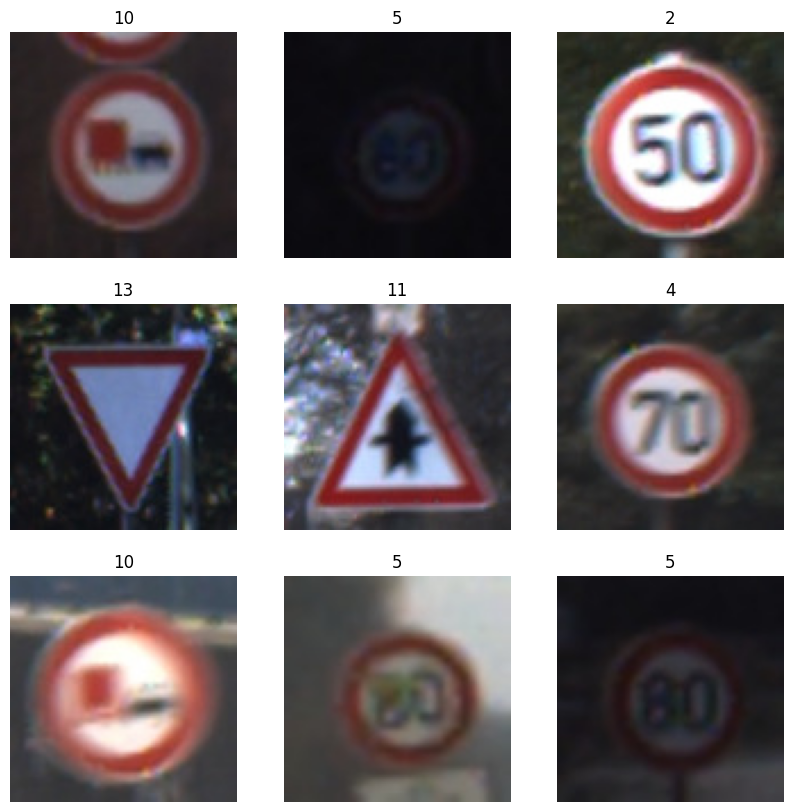

In [5]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images.tolist()[i]      
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image)*255
        plt.imshow(f.astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_generator))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(validation_generator))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.06666667 0.53333336
0.03137255 1.0


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Model Training!
num_classes = 43

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

strategy = tf.distribute.MirroredStrategy()

# Compile the model
# with strategy.scope():
    
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [11]:
tf.config.list_physical_devices('GPU')
print(f"Num GPUS Available: {len(tf.config.list_physical_devices('GPU'))}")

Num GPUS Available: 0


In [9]:
model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=3,
  verbose=1
)

Epoch 1/3
  30109/Unknown - 2583s 86ms/step - loss: 2.8814 - accuracy: 0.0811

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\jrzal\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "c:\Users\jrzal\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1919, in _run_once
      handle._run()
    File "c:\Users\jrzal\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\jrzal\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\jrzal\AppData\Local\Temp\ipykernel_9760\2370997833.py", line 1, in <module>
      model.fit(
    File "c:\Users\jrzal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\jrzal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\jrzal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\jrzal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\jrzal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\jrzal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\jrzal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 542, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "c:\Users\jrzal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 275, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad'
OOM when allocating tensor with shape[32,98,98,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1617]